### Import Library and function

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sklearn as sk
import pandas
import numpy as np
import tensorflow as tf
import random
import os
import collections
import math
import time
import datetime
from tensorflow.contrib import learn
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cross_validation import train_test_split
from matplotlib import pylab, pyplot

# Allow print picture or graph in Ipython
%matplotlib inline
# Allow print all arry if command print called
np.set_printoptions(threshold=np.inf)  

In [5]:
from load_data import load_file, separate_data_label, label_encoding

In [6]:
from New_CNN import TextCNN

### Loading Dataset

In [21]:
# Load classified Document
document1 = load_file("2007ChallengeTrainData.xml")
id_doc1, labels, words1 = separate_data_label(document1)

In [22]:
# Load unclassified Document
# Load more words from these document to improve word-embedding
document2 = load_file("2007ChallengeTestDataNoCodes.xml")
id_doc2, labels2, words2 = separate_data_label(document2)            # labels2 is empty variable

In [23]:
# Joint all the data together
id_doc = id_doc1 + id_doc2
words = words1 + words2

In [24]:
# Convert multidimension array into 1D array
words = [index.split() for index in words]                           # Separate words in sentences
words = [item for sublist in words for item in sublist]              # Turn multidimension list into 1D list

### Pre-training Word2vec 

In [25]:
vocabulary_size = len(words)

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  #print(count)
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

# reverse_dictionary used number index to access
# dictionary used word keyword to access
data, count, dictionary, reverse_dictionary = build_dataset(words)

del words  # Hint to reduce memory.
#add this line to modify
vocabulary_size = len(dictionary)
print('Dictionary size', len(dictionary))

Dictionary size 2000


In [26]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

In [27]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [28]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):  
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 5.644189
Nearest to x: stranding, lengths, periphery, change, increased, wedging, consideration, warranted,
Nearest to female: well, system, picture, margin, broncho, positioned, urination, continue,
Nearest to pneumonia: 8year, like, evaluated, cells, lower, shaped, ureteroceles, complex,
Nearest to thickening: ectasia, lobulation, progressive, parenchymal, nights, shadowing, ribs, lethargy,
Nearest to the: ultrasounds, reevaluate, extent, seven, grew, early, half, microscopic,
Nearest to be: bladder, expanded, mitrofanoff, details, straight, amplatzer, aortic, features,
Nearest to vesicoureteral: that, note, reviewing, chlorine, are, syndrome, variability, after,
Nearest to status: deformity, crackles, 38, beginning, distal, radiographically, coarctation, treatment,
Nearest to evaluate: thymus, combination, fever, identify, somewhat, retention, uganda, pyelocaliectasis,
Nearest to findings: pelvicaliceal, finding, caliber, cystography, zone, megaur

In [29]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

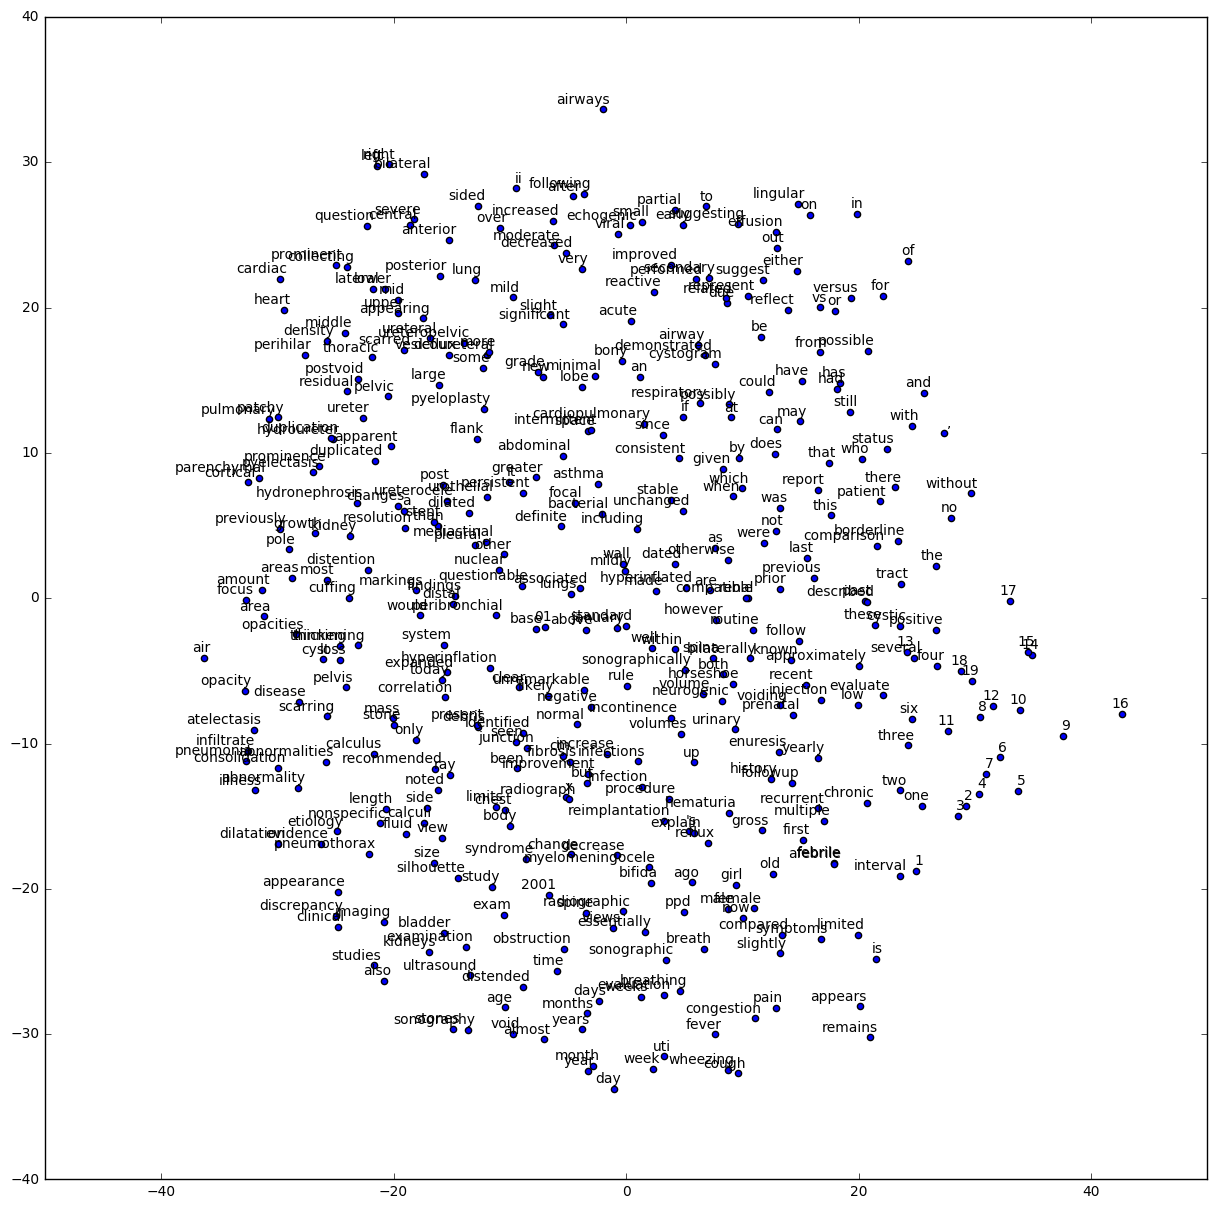

In [30]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

### Training 

##### Declare Parameter and Variable

In [31]:
embedding_dim = 128
filter_sizes = [1, 2, 3]
num_filters = 128
dropout_keep_prob = 0.5
l2_reg_lambda = 0.0

In [32]:
batch_size = 64
num_epochs = 200
evaluate_every = 100
checkpoint_every = 100

In [33]:
# Encoding words by one-hot encoding
max_document_length = max([len(x.split(" ")) for x in words1])
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
x = np.array(list(vocab_processor.fit_transform(words1)))

In [34]:
# One-hot-encoding label of each document
# There are 978 documents and 38 labels
y = label_encoding(labels, False)                                      # Encode data Label in DataFrame type
value = list(y.columns.values)
y = y.as_matrix()            

In [35]:
# One-hot-encoding label of each document
## Encode data Label in DataFrame type
y = label_encoding(labels, False)                                      # False for single label, True for multi-label
## Convert DataFrame type to numpy array for other calculation
y = y.as_matrix()                                                                                                                                                    

##### Prepare for Training Data and Test Data

In [36]:
# Randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

In [37]:
# Split train/test set
# TODO: This is very crude, should use cross-validation
#x_train, x_dev = train_test_split(x_shuffled, train_size = 0.2)
#y_train, y_dev = train_test_split(y_shuffled, train_size = 0.2)
x_train, x_dev = x_shuffled[:-500], x_shuffled[-500:]
y_train, y_dev = y_shuffled[:-500], y_shuffled[-500:]

In [38]:
# Sort each data and label into one pair
# then shuffle to ensure randomness 
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(len(data)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [39]:
batches = batch_iter(
        list(zip(x_train, y_train)), batch_size, num_epochs)

##### Prepare For The Neural Network and Training

In [40]:
## Arrays to stores training results
word2vec = True
step_store = []
accuracy_store = []
eval_step = []
eval_accuracy = []
eval_loss = []
eval_precision = []
eval_recall = []
eval_f1 = []

In [41]:
def train_step(x_batch, y_batch):
    """
    A single training step
    """
    feed_dict = {
        cnn.input_x: x_batch,
        cnn.input_y: y_batch,
        cnn.dropout_keep_prob: dropout_keep_prob
    }
    _, step, summaries, loss, accuracy = sess.run(
        [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
        feed_dict)
    step_store.append(step)
    accuracy_store.append(accuracy)
    print("step {}, loss {:g}, acc {:g}".format(step, loss, accuracy))
    train_summary_writer.add_summary(summaries, step)

In [42]:
def dev_step(x_batch, y_batch, writer=None):
    """
    Evaluates model on a dev set
    """
    feed_dict = {
        cnn.input_x: x_batch,
        cnn.input_y: y_batch,
        cnn.dropout_keep_prob: 1.0
    }
    step, summaries, loss, accuracy, y_p = sess.run(
        [global_step, dev_summary_op, cnn.loss, cnn.accuracy, cnn.y_p],
        feed_dict)
    eval_step.append(step)
    eval_accuracy.append(accuracy)
    eval_loss.append(loss)
    y_true = np.argmax(y_dev,1)
    precision = sk.metrics.precision_score(y_true, y_p)
    recall = sk.metrics.recall_score(y_true, y_p)
    f1_score = sk.metrics.f1_score(y_true, y_p)
    eval_precision.append(precision)
    eval_recall.append(recall)
    eval_f1.append(f1_score)
    print("step {}, loss {:g}, acc {:g}, precison {}, recall {}, f1_score {}.".format(step, loss, accuracy, precision, recall, f1_score))
    

In [43]:
# Training
# ==================================================
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=True,
      log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=len(y[0]),
            vocab_size=len(dictionary),
            embedding_size=embedding_dim,
            filter_sizes=filter_sizes,
            num_filters=num_filters,
            l2_reg_lambda=l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.merge_summary(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.scalar_summary("loss", cnn.loss)
        acc_summary = tf.scalar_summary("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.merge_summary([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.train.SummaryWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.merge_summary([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.train.SummaryWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.all_variables())

        # Store vocabulary embedded
        #dictionary.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.initialize_all_variables())

Writing to /home/ec2-user/tensorflow/Thesis/runs/1476236024



In [44]:
# ==================================================
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=True,
      log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=len(y[0]),
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size=embedding_dim,
            filter_sizes=filter_sizes,
            num_filters=num_filters,
            l2_reg_lambda=l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.merge_summary(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.scalar_summary("loss", cnn.loss)
        acc_summary = tf.scalar_summary("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.merge_summary([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.train.SummaryWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.merge_summary([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.train.SummaryWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.all_variables())

        # Store vocabulary embedded
        #dictionary.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.initialize_all_variables())
        
        if word2vec == True:
            # initial matrix with random uniform
            initW = np.random.uniform(-0.25,0.25,(len(vocab_processor.vocabulary_), embedding_dim))
            # load any vectors from the word2vec
            for indexWord in xrange(vocabulary_size):
                vectLocate = reverse_dictionary[indexWord]
                idx = vocab_processor.vocabulary_.get(vectLocate)
                if idx != 0:
                    initW[idx] = final_embeddings[indexWord]

            sess.run(cnn.W.assign(initW))        

Writing to /home/ec2-user/tensorflow/Thesis/runs/1476236025



In [45]:
# Evaluating
# ==================================================
start_time = time.time()
for batch in batches:
    x_batch, y_batch = zip(*batch)
    train_step(x_batch, y_batch)
    current_step = tf.train.global_step(sess, global_step)
    if current_step % evaluate_every == 0:
        print("\nEvaluation:")
        dev_step(x_dev, y_dev, writer=dev_summary_writer)
        print("")
        
time_exc = time.time() - start_time    

step 1, loss 3.9118, acc 0
step 2, loss 3.69029, acc 0.03125
step 3, loss 3.59617, acc 0.03125
step 4, loss 3.46883, acc 0.15625
step 5, loss 3.12407, acc 0.109375
step 6, loss 3.20854, acc 0.15625
step 7, loss 3.26595, acc 0.140625
step 8, loss 3.15547, acc 0.133333
step 9, loss 2.83447, acc 0.140625
step 10, loss 2.82773, acc 0.171875
step 11, loss 2.75683, acc 0.234375
step 12, loss 2.83073, acc 0.25
step 13, loss 2.82975, acc 0.21875
step 14, loss 2.8129, acc 0.203125
step 15, loss 2.73485, acc 0.25
step 16, loss 2.88168, acc 0.266667
step 17, loss 2.8186, acc 0.234375
step 18, loss 2.84188, acc 0.28125
step 19, loss 2.87398, acc 0.140625
step 20, loss 2.41781, acc 0.34375
step 21, loss 2.67975, acc 0.234375
step 22, loss 2.58357, acc 0.3125
step 23, loss 2.38861, acc 0.421875
step 24, loss 2.32017, acc 0.366667
step 25, loss 2.42667, acc 0.3125
step 26, loss 2.49766, acc 0.3125
step 27, loss 2.55354, acc 0.34375
step 28, loss 2.32602, acc 0.359375
step 29, loss 2.68644, acc 0.3281

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal

step 100, loss 1.47477, acc 0.69, precison 0.618003615397, recall 0.69, f1_score 0.617985184084.

step 101, loss 1.03882, acc 0.765625
step 102, loss 1.32217, acc 0.6875
step 103, loss 1.16785, acc 0.65625
step 104, loss 1.06339, acc 0.7
step 105, loss 1.0818, acc 0.78125
step 106, loss 1.18593, acc 0.734375
step 107, loss 1.32123, acc 0.65625
step 108, loss 0.887136, acc 0.78125
step 109, loss 0.971053, acc 0.78125
step 110, loss 1.09097, acc 0.8125
step 111, loss 1.17786, acc 0.71875
step 112, loss 0.855469, acc 0.833333
step 113, loss 1.06146, acc 0.78125
step 114, loss 1.14517, acc 0.78125
step 115, loss 0.812568, acc 0.875
step 116, loss 1.0111, acc 0.78125
step 117, loss 1.20648, acc 0.75
step 118, loss 1.08955, acc 0.8125
step 119, loss 1.00397, acc 0.765625
step 120, loss 1.16624, acc 0.666667
step 121, loss 1.05788, acc 0.734375
step 122, loss 0.892237, acc 0.8125
step 123, loss 1.04416, acc 0.734375
step 124, loss 1.04867, acc 0.75
step 125, loss 0.950765, acc 0.734375
step 1

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 200, loss 0.948286, acc 0.804, precison 0.727825914334, recall 0.804, f1_score 0.758976802617.

step 201, loss 0.379032, acc 0.921875
step 202, loss 0.575656, acc 0.859375
step 203, loss 0.383159, acc 0.890625
step 204, loss 0.431301, acc 0.828125
step 205, loss 0.481245, acc 0.875
step 206, loss 0.286783, acc 0.921875
step 207, loss 0.397245, acc 0.875
step 208, loss 0.309489, acc 0.9
step 209, loss 0.346707, acc 0.9375
step 210, loss 0.503325, acc 0.875
step 211, loss 0.384964, acc 0.875
step 212, loss 0.586469, acc 0.84375
step 213, loss 0.335351, acc 0.9375
step 214, loss 0.358936, acc 0.9375
step 215, loss 0.412629, acc 0.890625
step 216, loss 0.322675, acc 0.9
step 217, loss 0.527367, acc 0.875
step 218, loss 0.267313, acc 0.9375
step 219, loss 0.333919, acc 0.953125
step 220, loss 0.34245, acc 0.9375
step 221, loss 0.351287, acc 0.875
step 222, loss 0.429101, acc 0.890625
step 223, loss 0.477847, acc 0.859375
step 224, loss 0.588829, acc 0.8
step 225, loss 0.364178, acc 0.9

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 302, loss 0.2163, acc 0.9375
step 303, loss 0.202031, acc 0.984375
step 304, loss 0.18103, acc 0.933333
step 305, loss 0.276532, acc 0.9375
step 306, loss 0.21347, acc 0.9375
step 307, loss 0.148002, acc 1
step 308, loss 0.195457, acc 0.96875
step 309, loss 0.198448, acc 0.953125
step 310, loss 0.147194, acc 0.96875
step 311, loss 0.180265, acc 0.953125
step 312, loss 0.2499, acc 0.9
step 313, loss 0.221552, acc 0.953125
step 314, loss 0.173676, acc 0.953125
step 315, loss 0.210715, acc 0.96875
step 316, loss 0.270513, acc 0.921875
step 317, loss 0.210604, acc 0.953125
step 318, loss 0.126602, acc 0.953125
step 319, loss 0.170443, acc 0.984375
step 320, loss 0.179966, acc 1
step 321, loss 0.231403, acc 0.9375
step 322, loss 0.254231, acc 0.90625
step 323, loss 0.15387, acc 0.984375
step 324, loss 0.158232, acc 0.96875
step 325, loss 0.173257, acc 0.953125
step 326, loss 0.179399, acc 0.96875
step 327, loss 0.154662, acc 0.953125
step 328, loss 0.222779, acc 0.933333
step 329, loss

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 402, loss 0.0881055, acc 0.96875
step 403, loss 0.0919484, acc 0.96875
step 404, loss 0.0756674, acc 1
step 405, loss 0.174108, acc 0.9375
step 406, loss 0.129818, acc 0.96875
step 407, loss 0.126968, acc 0.984375
step 408, loss 0.0873086, acc 0.966667
step 409, loss 0.126403, acc 0.96875
step 410, loss 0.0647743, acc 1
step 411, loss 0.0807023, acc 0.984375
step 412, loss 0.121281, acc 0.96875
step 413, loss 0.0762358, acc 0.984375
step 414, loss 0.079897, acc 0.984375
step 415, loss 0.123756, acc 0.96875
step 416, loss 0.0404352, acc 1
step 417, loss 0.112377, acc 0.953125
step 418, loss 0.14858, acc 0.953125
step 419, loss 0.0634203, acc 1
step 420, loss 0.089246, acc 1
step 421, loss 0.0914529, acc 0.96875
step 422, loss 0.115498, acc 0.96875
step 423, loss 0.0950927, acc 0.984375
step 424, loss 0.0792137, acc 1
step 425, loss 0.0720005, acc 0.984375
step 426, loss 0.123162, acc 0.953125
step 427, loss 0.129517, acc 0.953125
step 428, loss 0.0982026, acc 0.984375
step 429, los

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 500, loss 0.861728, acc 0.808, precison 0.776556673274, recall 0.808, f1_score 0.772089741784.

step 501, loss 0.0726469, acc 0.984375
step 502, loss 0.0718253, acc 0.984375
step 503, loss 0.0685343, acc 1
step 504, loss 0.0829705, acc 1
step 505, loss 0.044125, acc 0.984375
step 506, loss 0.0473576, acc 1
step 507, loss 0.110309, acc 0.96875
step 508, loss 0.111488, acc 0.96875
step 509, loss 0.0559431, acc 1
step 510, loss 0.0478644, acc 1
step 511, loss 0.0663247, acc 0.984375
step 512, loss 0.0526949, acc 1
step 513, loss 0.0780762, acc 0.984375
step 514, loss 0.0705643, acc 0.984375
step 515, loss 0.0628287, acc 0.984375
step 516, loss 0.0757465, acc 0.984375
step 517, loss 0.0420843, acc 1
step 518, loss 0.122689, acc 0.953125
step 519, loss 0.0324895, acc 1
step 520, loss 0.0703622, acc 0.966667
step 521, loss 0.0400224, acc 1
step 522, loss 0.0575999, acc 1
step 523, loss 0.0864111, acc 0.984375
step 524, loss 0.0619224, acc 1
step 525, loss 0.036694, acc 1
step 526, loss 

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 603, loss 0.0429013, acc 1
step 604, loss 0.0703809, acc 0.984375
step 605, loss 0.0633766, acc 0.984375
step 606, loss 0.0324048, acc 1
step 607, loss 0.0171458, acc 1
step 608, loss 0.0860768, acc 0.966667
step 609, loss 0.044771, acc 1
step 610, loss 0.0526412, acc 0.984375
step 611, loss 0.0442466, acc 1
step 612, loss 0.0700556, acc 0.96875
step 613, loss 0.0273349, acc 1
step 614, loss 0.0255357, acc 1
step 615, loss 0.0357964, acc 1
step 616, loss 0.0266672, acc 1
step 617, loss 0.0627022, acc 0.984375
step 618, loss 0.045127, acc 0.984375
step 619, loss 0.0415947, acc 1
step 620, loss 0.0713545, acc 0.984375
step 621, loss 0.0781766, acc 0.984375
step 622, loss 0.0479031, acc 1
step 623, loss 0.0360064, acc 1
step 624, loss 0.0347467, acc 1
step 625, loss 0.0288437, acc 1
step 626, loss 0.027766, acc 1
step 627, loss 0.0321529, acc 1
step 628, loss 0.0961553, acc 0.953125
step 629, loss 0.0441697, acc 1
step 630, loss 0.0761055, acc 0.984375
step 631, loss 0.0675366, acc 0

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 700, loss 0.889464, acc 0.804, precison 0.77725586212, recall 0.804, f1_score 0.77360638569.

step 701, loss 0.0471195, acc 0.984375
step 702, loss 0.0329436, acc 1
step 703, loss 0.0336813, acc 0.984375
step 704, loss 0.0652322, acc 0.966667
step 705, loss 0.0255728, acc 1
step 706, loss 0.028995, acc 1
step 707, loss 0.0338015, acc 0.984375
step 708, loss 0.025485, acc 1
step 709, loss 0.0218678, acc 1
step 710, loss 0.0214677, acc 1
step 711, loss 0.0428322, acc 0.984375
step 712, loss 0.0136831, acc 1
step 713, loss 0.0296256, acc 1
step 714, loss 0.0294982, acc 1
step 715, loss 0.0353863, acc 0.984375
step 716, loss 0.0479637, acc 0.984375
step 717, loss 0.0131513, acc 1
step 718, loss 0.0244478, acc 1
step 719, loss 0.0248523, acc 1
step 720, loss 0.0207272, acc 1
step 721, loss 0.0571228, acc 1
step 722, loss 0.0177328, acc 1
step 723, loss 0.0387928, acc 1
step 724, loss 0.0284814, acc 0.984375
step 725, loss 0.0140242, acc 1
step 726, loss 0.0672296, acc 0.96875
step 727,

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 802, loss 0.0328938, acc 0.984375
step 803, loss 0.0281344, acc 1
step 804, loss 0.0217199, acc 1
step 805, loss 0.0180754, acc 1
step 806, loss 0.019636, acc 1
step 807, loss 0.0190414, acc 1
step 808, loss 0.0184243, acc 1
step 809, loss 0.0152084, acc 1
step 810, loss 0.01735, acc 1
step 811, loss 0.0515929, acc 0.984375
step 812, loss 0.0311556, acc 1
step 813, loss 0.040705, acc 1
step 814, loss 0.0239751, acc 1
step 815, loss 0.0189768, acc 1
step 816, loss 0.00903612, acc 1
step 817, loss 0.0209159, acc 1
step 818, loss 0.0177544, acc 1
step 819, loss 0.0106608, acc 1
step 820, loss 0.00873423, acc 1
step 821, loss 0.0406977, acc 0.984375
step 822, loss 0.0235305, acc 1
step 823, loss 0.0350273, acc 0.984375
step 824, loss 0.0502593, acc 1
step 825, loss 0.0138261, acc 1
step 826, loss 0.0244967, acc 0.984375
step 827, loss 0.0498681, acc 0.96875
step 828, loss 0.0205694, acc 1
step 829, loss 0.0165325, acc 1
step 830, loss 0.0209237, acc 1
step 831, loss 0.050197, acc 0.98

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 902, loss 0.00936811, acc 1
step 903, loss 0.0306314, acc 0.984375
step 904, loss 0.0250041, acc 1
step 905, loss 0.0285527, acc 0.984375
step 906, loss 0.038553, acc 0.984375
step 907, loss 0.0193717, acc 1
step 908, loss 0.033752, acc 1
step 909, loss 0.0135918, acc 1
step 910, loss 0.0199005, acc 1
step 911, loss 0.0414029, acc 0.984375
step 912, loss 0.019149, acc 1
step 913, loss 0.0137745, acc 1
step 914, loss 0.0203537, acc 1
step 915, loss 0.0181932, acc 1
step 916, loss 0.0212902, acc 1
step 917, loss 0.0119216, acc 1
step 918, loss 0.0189157, acc 1
step 919, loss 0.0378546, acc 0.984375
step 920, loss 0.0223327, acc 1
step 921, loss 0.0428329, acc 0.96875
step 922, loss 0.0385687, acc 0.984375
step 923, loss 0.0177288, acc 1
step 924, loss 0.0214651, acc 0.984375
step 925, loss 0.040615, acc 0.984375
step 926, loss 0.0217756, acc 1
step 927, loss 0.0166633, acc 1
step 928, loss 0.0149952, acc 1
step 929, loss 0.0264936, acc 1
step 930, loss 0.0315458, acc 0.984375
step 9

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 1000, loss 0.949025, acc 0.804, precison 0.772746117318, recall 0.804, f1_score 0.773076974624.

step 1001, loss 0.0104425, acc 1
step 1002, loss 0.00697484, acc 1
step 1003, loss 0.00892777, acc 1
step 1004, loss 0.0618446, acc 0.96875
step 1005, loss 0.0203413, acc 1
step 1006, loss 0.018307, acc 1
step 1007, loss 0.0139511, acc 1
step 1008, loss 0.0189929, acc 1
step 1009, loss 0.0480876, acc 0.984375
step 1010, loss 0.0154674, acc 1
step 1011, loss 0.0213265, acc 1
step 1012, loss 0.0110283, acc 1
step 1013, loss 0.0198657, acc 1
step 1014, loss 0.00913962, acc 1
step 1015, loss 0.0100917, acc 1
step 1016, loss 0.0156395, acc 1
step 1017, loss 0.0106134, acc 1
step 1018, loss 0.0092062, acc 1
step 1019, loss 0.0176158, acc 1
step 1020, loss 0.00989423, acc 1
step 1021, loss 0.0212724, acc 1
step 1022, loss 0.0110684, acc 1
step 1023, loss 0.00593253, acc 1
step 1024, loss 0.00977275, acc 1
step 1025, loss 0.0207543, acc 1
step 1026, loss 0.00847347, acc 1
step 1027, loss 0.031

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 1103, loss 0.0333224, acc 0.984375
step 1104, loss 0.00846582, acc 1
step 1105, loss 0.00712329, acc 1
step 1106, loss 0.0135182, acc 1
step 1107, loss 0.0394227, acc 0.984375
step 1108, loss 0.00970374, acc 1
step 1109, loss 0.00664671, acc 1
step 1110, loss 0.0072614, acc 1
step 1111, loss 0.00594426, acc 1
step 1112, loss 0.00868922, acc 1
step 1113, loss 0.0179122, acc 1
step 1114, loss 0.00893834, acc 1
step 1115, loss 0.00962069, acc 1
step 1116, loss 0.00416493, acc 1
step 1117, loss 0.0120321, acc 1
step 1118, loss 0.0212699, acc 1
step 1119, loss 0.0137326, acc 1
step 1120, loss 0.00760861, acc 1
step 1121, loss 0.0077988, acc 1
step 1122, loss 0.0245923, acc 1
step 1123, loss 0.0125794, acc 1
step 1124, loss 0.0156863, acc 1
step 1125, loss 0.0173203, acc 1
step 1126, loss 0.00763039, acc 1
step 1127, loss 0.0190445, acc 1
step 1128, loss 0.0149295, acc 1
step 1129, loss 0.00667767, acc 1
step 1130, loss 0.00232072, acc 1
step 1131, loss 0.00649408, acc 1
step 1132, loss

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 1200, loss 0.946155, acc 0.808, precison 0.774182004585, recall 0.808, f1_score 0.777895695928.

step 1201, loss 0.00513717, acc 1
step 1202, loss 0.010849, acc 1
step 1203, loss 0.0152314, acc 0.984375
step 1204, loss 0.0263321, acc 0.984375
step 1205, loss 0.00904629, acc 1
step 1206, loss 0.00418747, acc 1
step 1207, loss 0.00529922, acc 1
step 1208, loss 0.0166204, acc 1
step 1209, loss 0.00397511, acc 1
step 1210, loss 0.00604652, acc 1
step 1211, loss 0.0206959, acc 0.984375
step 1212, loss 0.00400592, acc 1
step 1213, loss 0.00328681, acc 1
step 1214, loss 0.0129673, acc 1
step 1215, loss 0.0101114, acc 1
step 1216, loss 0.00479537, acc 1
step 1217, loss 0.00539896, acc 1
step 1218, loss 0.0183505, acc 0.984375
step 1219, loss 0.00970248, acc 1
step 1220, loss 0.00626459, acc 1
step 1221, loss 0.00627878, acc 1
step 1222, loss 0.0110324, acc 1
step 1223, loss 0.00385432, acc 1
step 1224, loss 0.00640192, acc 1
step 1225, loss 0.00781577, acc 1
step 1226, loss 0.00673671, ac

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 1302, loss 0.0100994, acc 1
step 1303, loss 0.0507927, acc 0.984375
step 1304, loss 0.00517609, acc 1
step 1305, loss 0.010867, acc 1
step 1306, loss 0.010441, acc 1
step 1307, loss 0.00752803, acc 1
step 1308, loss 0.0424242, acc 0.984375
step 1309, loss 0.00848689, acc 1
step 1310, loss 0.00966663, acc 1
step 1311, loss 0.00727148, acc 1
step 1312, loss 0.00380283, acc 1
step 1313, loss 0.00484803, acc 1
step 1314, loss 0.00389944, acc 1
step 1315, loss 0.00800214, acc 1
step 1316, loss 0.00569876, acc 1
step 1317, loss 0.0173827, acc 0.984375
step 1318, loss 0.0130443, acc 1
step 1319, loss 0.0186543, acc 1
step 1320, loss 0.0398065, acc 0.966667
step 1321, loss 0.00432159, acc 1
step 1322, loss 0.00876353, acc 1
step 1323, loss 0.0527235, acc 0.984375
step 1324, loss 0.0171175, acc 0.984375
step 1325, loss 0.00926361, acc 1
step 1326, loss 0.00739097, acc 1
step 1327, loss 0.0134831, acc 1
step 1328, loss 0.00567557, acc 1
step 1329, loss 0.0538987, acc 0.984375
step 1330, los

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 1400, loss 0.987043, acc 0.806, precison 0.786442179617, recall 0.806, f1_score 0.775796291705.

step 1401, loss 0.0326475, acc 0.984375
step 1402, loss 0.00475473, acc 1
step 1403, loss 0.0332528, acc 0.984375
step 1404, loss 0.00858645, acc 1
step 1405, loss 0.00516133, acc 1
step 1406, loss 0.00874909, acc 1
step 1407, loss 0.0049929, acc 1
step 1408, loss 0.0031687, acc 1
step 1409, loss 0.0091094, acc 1
step 1410, loss 0.020704, acc 0.984375
step 1411, loss 0.00481896, acc 1
step 1412, loss 0.00444553, acc 1
step 1413, loss 0.0252924, acc 0.984375
step 1414, loss 0.00488496, acc 1
step 1415, loss 0.00482038, acc 1
step 1416, loss 0.00727654, acc 1
step 1417, loss 0.00922049, acc 1
step 1418, loss 0.00319282, acc 1
step 1419, loss 0.00303366, acc 1
step 1420, loss 0.00334885, acc 1
step 1421, loss 0.0149035, acc 0.984375
step 1422, loss 0.00704383, acc 1
step 1423, loss 0.0141498, acc 0.984375
step 1424, loss 0.0030467, acc 1
step 1425, loss 0.0106052, acc 1
step 1426, loss 0.

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

step 1502, loss 0.00627661, acc 1
step 1503, loss 0.00387879, acc 1
step 1504, loss 0.0029845, acc 1
step 1505, loss 0.0077209, acc 1
step 1506, loss 0.00311925, acc 1
step 1507, loss 0.00664422, acc 1
step 1508, loss 0.00478455, acc 1
step 1509, loss 0.00914208, acc 1
step 1510, loss 0.0176229, acc 0.984375
step 1511, loss 0.00393445, acc 1
step 1512, loss 0.0028584, acc 1
step 1513, loss 0.00546927, acc 1
step 1514, loss 0.00362327, acc 1
step 1515, loss 0.0220241, acc 0.984375
step 1516, loss 0.00500605, acc 1
step 1517, loss 0.00478961, acc 1
step 1518, loss 0.0120238, acc 1
step 1519, loss 0.011756, acc 1
step 1520, loss 0.00280332, acc 1
step 1521, loss 0.0033474, acc 1
step 1522, loss 0.00494464, acc 1
step 1523, loss 0.00451543, acc 1
step 1524, loss 0.00479132, acc 1
step 1525, loss 0.00230026, acc 1
step 1526, loss 0.0249717, acc 0.984375
step 1527, loss 0.00320656, acc 1
step 1528, loss 0.00358931, acc 1
step 1529, loss 0.00932132, acc 1
step 1530, loss 0.00884104, acc 1
ste

/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ec2-user/tensorflow/local/lib64/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" 

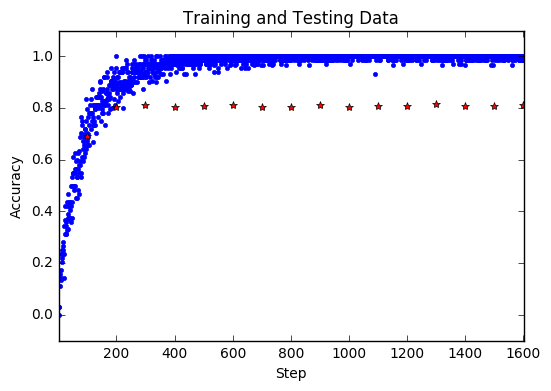

In [46]:
pyplot.plot(step_store,accuracy_store,'b.')
pyplot.plot(eval_step,eval_accuracy,'r*')
pyplot.xlim(min(step_store)-0.1,max(step_store)+0.1)
pyplot.ylim(min(accuracy_store)-0.1,max(accuracy_store)+0.1)
pyplot.xlabel("Step")
pyplot.ylabel("Accuracy")
pyplot.title("Training and Testing Data")
pyplot.show()

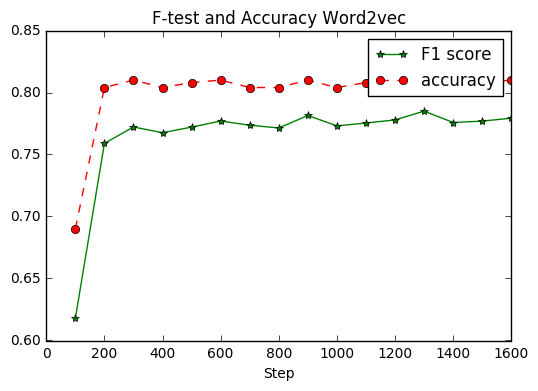

In [47]:
pyplot.plot(eval_step,eval_f1,marker='*', color='g',label='F1 score')
pyplot.plot(eval_step,eval_accuracy,marker='o', linestyle='--', color='r',label='accuracy')
pyplot.xlabel('Step')
pyplot.title('F-test and Accuracy Word2vec')
pyplot.legend()
pyplot.show()

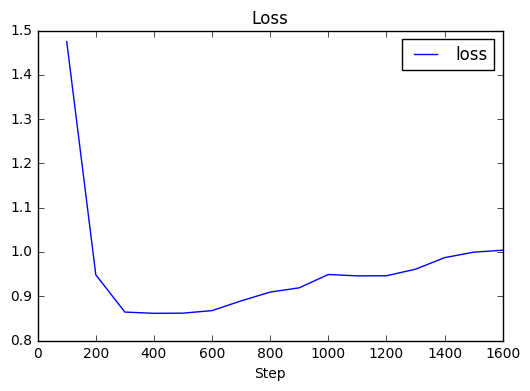

In [48]:
pyplot.plot(eval_step,eval_loss,label='loss')
pyplot.xlabel('Step')
pyplot.title('Loss')
pyplot.legend()
pyplot.show()

In [49]:
print(eval_accuracy)
print(eval_f1)
print(eval_loss)
print(time_exc)

[0.69, 0.80400002, 0.81, 0.80400002, 0.80800003, 0.81, 0.80400002, 0.80400002, 0.81, 0.80400002, 0.80800003, 0.80800003, 0.81599998, 0.80599999, 0.80800003, 0.81]
[0.61798518408423797, 0.75897680261709144, 0.77218991763278888, 0.76756397535041132, 0.77208974178415057, 0.7769995592870188, 0.7736063856899672, 0.77142484687629564, 0.78146787137215312, 0.77307697462428515, 0.77541251870782146, 0.7778956959275064, 0.78499689597477518, 0.77579629170524533, 0.77693059146662191, 0.77928851397137899]
[1.474773, 0.948286, 0.86418271, 0.86138767, 0.86172813, 0.86755973, 0.88946444, 0.9093585, 0.91897577, 0.94902468, 0.94591081, 0.94615513, 0.96094412, 0.9870435, 0.99942249, 1.0039407]
64.1788408756


In [13]:
base_loss = [1.7281258, 1.5522296, 1.4491031, 1.3495785, 1.4393047, 1.4317033, 1.4049853, 1.4099716, 1.3809965, 1.3955806, 1.3896536, 1.4224104, 1.3782725, 1.3803085, 1.5221581, 1.3703176]

In [14]:
word2vec_loss =  [1.5932866, 1.08655, 0.98018837, 0.94577873, 0.94235796, 0.95173478, 0.95664454, 0.98016202, 0.98116165, 0.99294007, 1.0032777, 0.99938524, 1.0162528, 1.0250241, 1.0369563, 1.0540725]

In [15]:
nonword2vec_loss = [1.4502351, 1.1715344, 1.1152127, 1.0924531, 1.0984006, 1.0733554, 1.0843096, 1.1178634, 1.1315157, 1.1427549, 1.1529741, 1.1498868, 1.1794428, 1.155201, 1.1521715, 1.1669934]

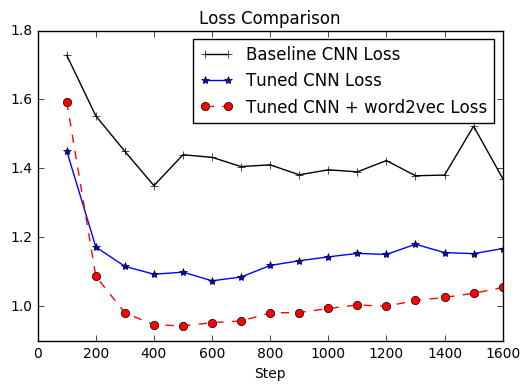

In [23]:
pyplot.plot(eval_step,base_loss,marker='+', color='black',label='Baseline CNN Loss')
pyplot.plot(eval_step,nonword2vec_loss,marker='*', color='blue',label='Tuned CNN Loss')
pyplot.plot(eval_step,word2vec_loss,marker='o', linestyle='--', color='r',label='Tuned CNN + word2vec Loss')
pyplot.xlabel('Step')
pyplot.title('Loss Comparison')
pyplot.legend()
pyplot.show()

In [46]:
base_acc = [0.574, 0.61799997, 0.63200003, 0.66000003, 0.65600002, 0.662, 0.65200001, 0.66000003, 0.662, 0.68000001, 0.67799997, 0.68800002, 0.68599999, 0.69599998, 0.70200002, 0.69999999]

In [47]:
base_f1 = [0.51746541682382452, 0.56294755445437927, 0.57999633666492578, 0.6045074540313824, 0.60745004503783073, 0.60983174957721076, 0.60319916785785044, 0.61118407581701428, 0.61440020930793371, 0.62632138062823639, 0.6316468826909869, 0.63965583501326539, 0.63822825100918246, 0.65047112525121331, 0.65834669629269382, 0.6506271084032581]

In [57]:
word2vec_acc = [0.69, 0.80400002, 0.81, 0.80400002, 0.80800003, 0.81, 0.80400002, 0.80400002, 0.81, 0.80400002, 0.80800003, 0.80800003, 0.81599998, 0.80599999, 0.80800003, 0.81]

In [58]:
word2vec_f1 = [0.61798518408423797, 0.75897680261709144, 0.77218991763278888, 0.76756397535041132, 0.77208974178415057, 0.7769995592870188, 0.7736063856899672, 0.77142484687629564, 0.78146787137215312, 0.77307697462428515, 0.77541251870782146, 0.7778956959275064, 0.78499689597477518, 0.77579629170524533, 0.77693059146662191, 0.77928851397137899]

In [59]:
eval_step = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600]

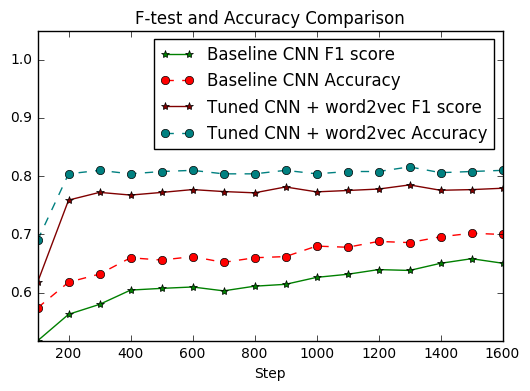

In [63]:
pyplot.plot(eval_step,base_f1,marker='*', color='g',label='Baseline CNN F1 score')
pyplot.plot(eval_step,base_acc,marker='o', linestyle='--', color='r',label='Baseline CNN Accuracy')
pyplot.plot(eval_step,word2vec_f1,marker='*', color='maroon',label='Tuned CNN + word2vec F1 score')
pyplot.plot(eval_step,word2vec_acc,marker='o', linestyle='--', color='teal',label='Tuned CNN + word2vec Accuracy')
pyplot.xlim(min(eval_step)-0.1,max((eval_step))+0.1)
pyplot.ylim(min(word2vec_f1)-0.1,1.05)
pyplot.xlabel("Step")
pyplot.xlabel('Step')
pyplot.title('F-test and Accuracy Comparison')
pyplot.legend()
pyplot.show()